## Mnist CNN
- layer 1 </br>
Conv: in_c = 1, out_c = 32, kernel = 3, stride = 1, padding = 1 </br>
ReLU: </br>
MaxPool: kernel = 2, stride = 2 </br>

- layer 2 </br>
Conv: in_c = 32, out_c = 64, kernel = 3, stride = 1, padding = 1 </br>
ReLU: </br>
MaxPool: kernel = 2, stride = 2 </br>
</br>
- view </br>
FC

- Cross Entropy Loss </br>
SoftMax </br>
NLL Loss


- view => (batchsize x [7, 7, 64]) => batch_size x [3136]) </br>
Fully_Connect layer => (input = 3136, output = 10)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.models import resnet
from torch.utils.data import DataLoader
from PIL import Image
import tqdm
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch.nn.init

inputs = torch.Tensor(1, 1, 28, 28) # (batch, channel, height, width)



In [41]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

In [10]:
learning_rate = 3e-4
training_epochs = 15
batch_size = 10

In [11]:
# mnist digit data
mnist_train = dsets.MNIST(root='MNIST_data/', 
                          train = True,
                          transform= transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

In [12]:
# fashion mnist data
fashion_train = dsets.FashionMNIST.train_data(root="data/FashionMNIST/train",
                                         train=True,
                                         transform=transforms.ToTensor(),
                                         download=True)
fashion_test = dsets.FashionMNIST.test_data(root="data/FashionMNIST/test",
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=True)

### Create data

In [13]:
fashion_train_loader = DataLoader(fashion_train,
                                  batch_size=10,
                                  shuffle=True,
                                  drop_last= True)
fashion_test_loader = DataLoader(fashion_test,
                                 batch_size=10,
                                 shuffle=True,
                                 drop_last= True)

torch.Size([10, 1, 28, 28])
tensor([7, 6, 7, 2, 4, 6, 5, 7, 2, 1])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


<function matplotlib.pyplot.show(close=None, block=None)>

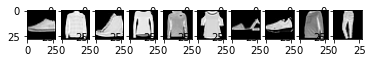

In [45]:
fashion_train_imgs, fashion_train_labels = next(iter(fashion_train_loader))
num_classes = len(dsets.FashionMNIST.classes)
print(fashion_train_imgs.shape)
print(fashion_train_labels)
print(dsets.FashionMNIST.classes)


for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow( fashion_train_imgs[i].permute(1, 2, 0), cmap='gray')
plt.show

### Create a Model

In [36]:
# ResNet 101 model
model = resnet.resnet101()

In [42]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.NLLLoss()

In [44]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy': Accuracy(),
    'nll': Loss(criterion),
    'confusion matrix': ConfusionMatrix(num_classes=10),
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy': [], 'loss':[]}
validation_history = {'accuracy': [], 'loss': []}
last_epoch = []

In [52]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(7*7*64, 10, bias=True) # Fully connected Layer
        nn.init.xavier_uniform_(self.fc.weight) # FC 레이어 초기화

    def forward(self, x): # x가 out됨
        out = self.layer1(x)
        out = self.layer2(out)

        out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # chnl-in, out, kernel
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.fc1 = nn.Linear(1024, 512) # [64*4*4, x]
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)   # 10 classes
        self.pool = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.50)

        self.layer1 = nn.Sequential(
            self.conv1,     # x in [bs, 1, 28, 28]
            nn.ReLU(),      # size([bs, 32, 24, 24])
            self.pool,  # size([bs, 32, 12, 12])
            self.drop1
        )

        self.layer2 = nn.Sequential(
            self.conv2,             # size([bs, 64, 8, 8])
            nn.ReLU(),    
            self.pool   # size([bs, 64, 4, 4])
        )

        self.layer3 = nn.Sequential(
            self.fc1,   # size(bs, 512)
            nn.ReLU(),
            self.drop2,
            self.fc2,   # size(bs, 256)
            nn.ReLU(),
            self.fc3   # size(bs, 10)
        )

    def forward(self, x):
        # conv phase                    
        out = self.layer1(x)
        out = self.layer2(out)


        # neural network phase
        out = out.reshape(-1, 1024)    # size([bs, 1024]) 
        out = self.layer3(out)     
        return out

def accuracy(model, ds):
    ldr = T.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=False)
    n_correct = 0
    for data in ldr:
        (pixels, labels) = data
    with T.no_grad():
        oupts = model(pixels)
        _, predicteds = torch.max(oupts, 1)
        n_correct += (predicteds == labels).sum().item()

    acc = (n_correct * 1.0) / len(ds)
    return acc
        

In [61]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    

In [62]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


tensor(3)


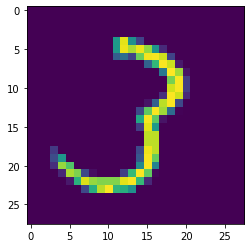

In [64]:
plt.imshow(x[8].permute(1, 2, 0))
print(y[8])

### Training

In [ ]:
train_epoch = 50

trainer = create

In [65]:
# Training

for epoch in range(training_epochs):
    avg_cost = 0 # loss를 담음
    X, Y = next(iter(test_loader)) # X: image, Y: label
    X = X.to(device) # cuda 연산을 하기 위해 필요
    Y = Y.to(device)

    # Compute prediction and loss
    pred = model(X) # 가설(hypothesis) H(x) = Wx + b, 예측값 prediction
    loss = criterion(pred, Y) # loss_fn
    
    # Backpropagation
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

    avg_cost += loss / train_epoch
    print('[Epoch: {}] loss = {}'.format(epoch+1, avg_cost))
    print('Learning Finished!')
        


[Epoch: 1] loss = 0.002301423577591777
Learning Finished!
[Epoch: 2] loss = 0.002060042694211006
Learning Finished!
[Epoch: 3] loss = 0.00443555461242795
Learning Finished!
[Epoch: 4] loss = 0.0023163347505033016
Learning Finished!
[Epoch: 5] loss = 0.002239817753434181
Learning Finished!
[Epoch: 6] loss = 0.002327391179278493
Learning Finished!
[Epoch: 7] loss = 0.0022840392775833607
Learning Finished!
[Epoch: 8] loss = 0.0023268393706530333
Learning Finished!
[Epoch: 9] loss = 0.002273962600156665
Learning Finished!
[Epoch: 10] loss = 0.0023027819115668535
Learning Finished!
[Epoch: 11] loss = 0.00231882743537426
Learning Finished!
[Epoch: 12] loss = 0.002242285292595625
Learning Finished!
[Epoch: 13] loss = 0.0022990726865828037
Learning Finished!
[Epoch: 14] loss = 0.0023567560128867626
Learning Finished!
[Epoch: 15] loss = 0.0023155990056693554
Learning Finished!


In [67]:
model = Net().to(device)

learning_rate = 0.005
training_epochs = 50
ep_log_interval = 5
learning_rate = 0.0005

loss_func = nn.CrossEntropyLoss() # does log-softmax()
optimizer = torch.optim.SGD(model.parameters(),learning_rate)
model.train()
for epoch in range(training_epochs):
    ep_loss = 0
    for (batch_idx, batch) in enumerate(train_loader):
        (X, y) = batch # X = pixels, y = target labels
        (X, y) = (X.to(device), y.to(device))
        optimizer.zero_grad()
        output = model(X)
        loss_val = criterion(output, y) # a tensor
        ep_loss += loss_val.item() # accumulate
        loss_val.backward() # compute grads
        optimizer.step()
    if epoch % ep_log_interval == 0:
        print("epoch = %4d loss = %0.4f"%(epoch, ep_loss))
print("Done")


epoch =    0 loss = 13749.1517


In [9]:
xx = torch.Tensor(5, 3, 511, 511) # b x c x h x w
xx.shape

torch.Size([5, 3, 511, 511])

In [23]:
atrouse_layer = nn.Sequential(nn.Conv2d(3, 64, 7, stride=2, padding=3),
                              nn.BatchNorm2d(64),
                              nn.ReLU(),
                              nn.MaxPool2d(3, 2, 1)
)

project = nn.Sequential(
            nn.Conv2d(256, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )

classifier = nn.Sequential(
    nn.Conv2d(304, 256, 3, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 5, 1)
)

representation = nn.Sequential(
    nn.Conv2d(304, 256, 3, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, 1)
)

resnet_m = resnet.resnet101(pretrained=True)

In [26]:
out = atrouse_layer(xx) # 5 x 64 x 128 x 128
print(out.shape)


#model_v3 = get_model(model_name='deeplabv3p', num_classes=5, output_dim=256)
# encoder
out_low = resnet_m.layer1(out)  # 5 x 256 x 128 x 128
out = resnet_m.layer2(out_low)  # 5 x 512 x 64 x 64
out = resnet_m.layer3(out)      # 5 x 1024 x 32 x 32
out = resnet_m.layer4(out)      # 5 x 2048 x 16 x 16
feature = ASPP(2048, [6, 12, 18])(out) # 5 x 256 x 16 x 16

# decoder
out_low = project(out_low) # 5 x 48 x 128 x 128
# interpolate: 작은 feature의 크기를 크게 변경시킬 때 사용됨(upsampling)
output_feature = F.interpolate(feature, size=out_low.shape[2:], mode='bilinear', align_corners=True)
# 5 x 256 x 128 x 128
print(output_feature.shape)
prediction = classifier(torch.cat([out_low, output_feature], dim =1 )) # 5 x 5 x 128 x 128
rep = representation(torch.cat([out_low, output_feature], dim=1))  # 5 x 256 x 128 x 128
print("prediction: \t\t", prediction.shape)
print("representation: \t", rep.shape)


torch.Size([5, 64, 128, 128])
torch.Size([5, 256, 128, 128])
prediction: 		 torch.Size([5, 5, 128, 128])
representation: 	 torch.Size([5, 256, 128, 128])


In [28]:
datasets.transform(xx)

c:\Users\Admin\anaconda3\envs\imgseg\lib\site-packages\torchvision\transforms\functional.py:404: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


TypeError: cannot unpack non-iterable builtin_function_or_method object

In [ ]:
conv1 = nn.Conv2d(1, 32, 3, padding=1)
conv2 = nn.Conv2d(32, 64, 3, padding=1)
pool = nn.MaxPool2d(2)
fc = nn.Linear(3136, 10)
relu = nn.ReLU()
relu_in = nn.ReLU(True)
bn1 = nn.BatchNorm2d

In [ ]:
out = conv1(xx) # 1, 32, 28 x 28
out = bn1(out)
out = relu_in(out)

out = pool(out)
out = conv2(out) # 32, 64, 28 x 28
out = pool(out) # maxpool 2, b x 64 x 14 x 14
out = pool(out) # maxpool 2, b x 64 x 7 x 7
out = out.view(out.size(0), -1) # b x 3136
out = fc(out)

print(out.shape)
print(out)

TypeError: empty() received an invalid combination of arguments - got (Tensor, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
X_train = DataLoader(mnist_train, 5, shuffle=True, )

IndexError: index 1 is out of bounds for dimension 0 with size 1

: 